#Building a Random Forest Classifier

#Dataset 1:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

In [ ]:
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:

                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [ ]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [ ]:
from random import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

df0 = datasets.load_breast_cancer()
X = df0.data
y = df0.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

#predicting values for model with 10 tree estimators
clf = RandomForest(n_trees=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc =  accuracy(y_test, predictions)
print(acc)

0.9298245614035088


In [ ]:
#predicting values for model with 20 tree estimators
clf1 = RandomForest(n_trees=20)
clf1.fit(X_train, y_train)
predictions = clf1.predict(X_test)

acc =  accuracy(y_test, predictions)
print(acc)

0.9298245614035088


In [ ]:
#predicting values for model with 30 tree estimators
clf2 = RandomForest(n_trees=30)
clf2.fit(X_train, y_train)
predictions = clf2.predict(X_test)

acc =  accuracy(y_test, predictions)
print(acc)

0.9385964912280702


predicting values for model with more tree estimators leads to increase in the accuracy

# Building a Random Forest classifier using libraries

#Dataset 2:

In [ ]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

1.0

# Compare the results of random forest with and without selecting important features only for building the classifier on dataset 1, 2 and 3.

# Dataset 1:

In [ ]:
# Load Dataset 1
df = pd.read_csv('/content/Iris.csv')
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Build Random Forest Classifier without Feature Selection
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calculate Accuracy
acc_no_selection = accuracy_score(y_test, y_pred)
print("Accuracy without Feature Selection on Dataset 1:", acc_no_selection)

Accuracy without Feature Selection on Dataset 1: 1.0


In [ ]:
# Perform Feature Selection
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
selected_features = feature_imp[feature_imp > 0.05].index  # Example threshold for selection

# Build Random Forest Classifier with Feature Selection
clf_selected = RandomForestClassifier(n_estimators=100, random_state=32)
clf_selected.fit(X_train[selected_features], y_train)
y_pred_selected = clf_selected.predict(X_test[selected_features])

# Calculate Accuracy
acc_with_selection = accuracy_score(y_test, y_pred_selected)
print("Important Features:" , feature_imp)
print("Accuracy with Feature Selection on Dataset 1:", acc_with_selection)

Important Features: Id               0.394211
PetalWidthCm     0.288313
PetalLengthCm    0.266490
SepalLengthCm    0.042442
SepalWidthCm     0.008543
dtype: float64
Accuracy with Feature Selection on Dataset 1: 1.0


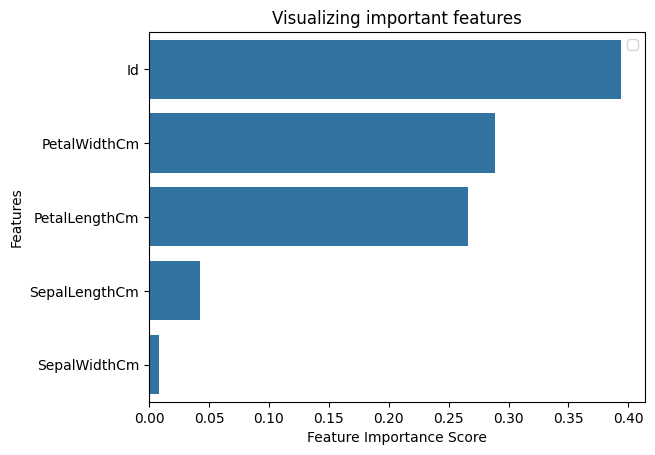

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing important features")
plt.legend()
plt.show();

# Dataset 2:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Load and preprocess Dataset 2
data2 = pd.read_csv('/content/Breast_cancer_data.csv')
X2 = data2.drop('diagnosis', axis=1)
y2 = data2['diagnosis']

# Train-Test Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=32)

# Build Random Forest Classifier without Feature Selection
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)

# Calculate Accuracy
acc_no_selection2 = accuracy_score(y_test2, y_pred2)
print("Accuracy without Feature Selection on Dataset 2:", acc_no_selection2)

Accuracy without Feature Selection on Dataset 2: 0.868421052631579


In [ ]:
# Perform Feature Selection
feature_imp2 = pd.Series(clf2.feature_importances_, index=X2.columns).sort_values(ascending=False)
selected_features2 = feature_imp2[feature_imp2 > 0.2].index  # Example threshold for selection

# Build Random Forest Classifier with Feature Selection
clf_selected2 = RandomForestClassifier(n_estimators=100, random_state=32)
clf_selected2.fit(X_train2[selected_features2], y_train2)
y_pred_selected2 = clf_selected2.predict(X_test2[selected_features2])

# Calculate Accuracy
acc_with_selection2 = accuracy_score(y_test2, y_pred_selected2)
print("Important Features:" , feature_imp2)
print("Accuracy with Feature Selection on Dataset 2:", acc_with_selection2)

Important Features: mean_area          0.294334
mean_perimeter     0.282802
mean_radius        0.217915
mean_texture       0.104647
mean_smoothness    0.100302
dtype: float64
Accuracy with Feature Selection on Dataset 2: 0.8070175438596491


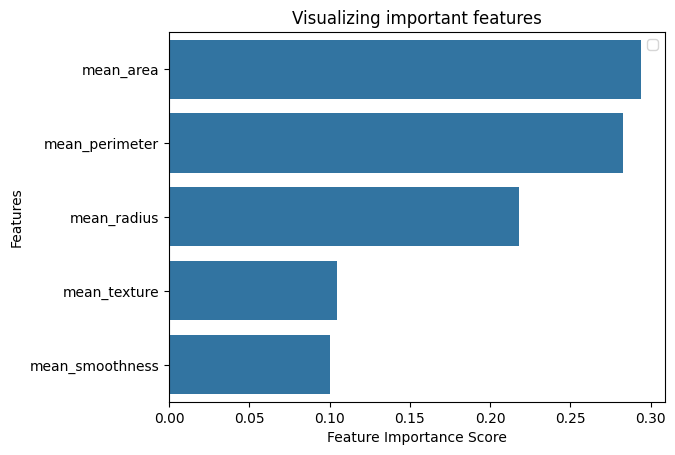

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp2, y=feature_imp2.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing important features")
plt.legend()
plt.show();

# Dataset 3:

In [ ]:
df = pd.read_csv('/content/2013.csv')

In [ ]:
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_AGE80,_IMPEDUC,_IMPMRTL,_IMPHOME,RCSBRAC1,RCSRACE1,RCHISLA1,RCSBIRTH,TYPEINDS,TYPEWORK
0,1.0,1.0,b'01092013',b'01',b'09',b'2013',1100.0,2.013001e+09,2.013001e+09,1.0,...,60.0,6.0,2.0,1.0,NaN,b'',b'',b'',b'',b''
1,1.0,1.0,b'01192013',b'01',b'19',b'2013',1100.0,2.013001e+09,2.013001e+09,1.0,...,50.0,5.0,1.0,1.0,NaN,b'',b'',b'',b'',b''
2,1.0,1.0,b'01192013',b'01',b'19',b'2013',1100.0,2.013001e+09,2.013001e+09,1.0,...,55.0,6.0,1.0,1.0,NaN,b'',b'',b'',b'',b''
3,1.0,1.0,b'01112013',b'01',b'11',b'2013',1100.0,2.013001e+09,2.013001e+09,1.0,...,64.0,4.0,1.0,1.0,NaN,b'',b'',b'',b'',b''
4,1.0,2.0,b'02062013',b'02',b'06',b'2013',1100.0,2.013001e+09,2.013001e+09,1.0,...,66.0,6.0,1.0,1.0,NaN,b'',b'',b'',b'',b''


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18403 entries, 0 to 18402
Columns: 336 entries, _STATE to TYPEWORK
dtypes: float64(324), object(12)
memory usage: 47.2+ MB


In [ ]:
df.describe()

,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,...,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3,_AGE80,_IMPEDUC,_IMPMRTL,_IMPHOME,RCSBRAC1
count,18403.000000,18403.000000,18403.000000,1.840300e+04,1.840300e+04,18403.0,13597.000000,1.0,13597.0,13597.0,...,18402.000000,18402.000000,6266.000000,6266.000000,16902.000000,18402.000000,18402.000000,18402.000000,18402.000000,0.0
mean,2.609194,6.496332,1112.932674,2.013003e+09,2.013003e+09,1.0,1.000074,1.0,1.0,1.0,...,1.668840,1.736061,2.118098,2.283434,1.928647,55.150799,4.759483,2.201554,1.321541,NaN
std,1.551761,3.508684,33.557034,1.621870e+03,1.621870e+03,0.0,0.008576,NaN,0.0,0.0,...,2.115669,2.109227,2.251704,2.584521,1.417013,16.872611,1.052129,1.536425,0.565403,NaN
min,1.000000,1.000000,1100.000000,2.013000e+09,2.013000e+09,1.0,1.000000,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,NaN
25%,1.000000,4.000000,1100.000000,2.013001e+09,2.013001e+09,1.0,1.000000,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,43.000000,4.000000,1.000000,1.000000,NaN
50%,2.000000,6.000000,1100.000000,2.013003e+09,2.013003e+09,1.0,1.000000,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,2.000000,57.000000,5.000000,1.000000,1.000000,NaN
75%,4.000000,10.000000,1100.000000,2.013004e+09,2.013004e+09,1.0,1.000000,1.0,1.0,1.0,...,1.000000,1.000000,2.000000,2.000000,2.000000,68.000000,6.000000,3.000000,2.000000,NaN
max,5.000000,12.000000,1200.000000,2.013007e+09,2.013007e+09,1.0,2.000000,1.0,1.0,1.0,...,9.000000,9.000000,9.000000,9.000000,9.000000,80.000000,6.000000,6.000000,3.000000,NaN


In [ ]:
df['_RFHLTH'].value_counts()

1.0    14056
2.0     4280
9.0       67
Name: _RFHLTH, dtype: int64

In [ ]:
# Replace 2 with 0 in '_RFHLTH' column
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})

In [ ]:
df['_RFHLTH'].value_counts()

1.0    14056
0.0     4280
9.0       67
Name: _RFHLTH, dtype: int64

In [ ]:
# Keep only rows with values 0 or 1 in '_RFHLTH' column
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()

In [ ]:
# Rename '_RFHLTH' column to 'Label'
df = df.rename(columns = {'_RFHLTH': 'Label'})

In [ ]:
# Calculate percentage of data in each column
percentOfData = df.count()*100/9980

In [ ]:
 # Identify columns with less than 50% data
badFeatures = percentOfData.where(percentOfData<50).dropna()

In [ ]:
# Remove columns with missing values
df = df.drop(columns = badFeatures.index.to_list())

In [ ]:
# Remove all non float data
df = df.select_dtypes(include=['float64'])

In [ ]:
#Removing few more columns
df = df.drop(columns=['SEX','_STATE','FMONTH','SEQNO','DISPCODE','MARITAL','EDUCA','POORHLTH', 'PHYSHLTH', 'GENHLTH', 'HLTHPLN1', 'MENTHLTH'])

In [ ]:
df.head()

,_PSU,CTELENUM,PVTRESD1,STATERES,CELLFON3,NUMADULT,NUMMEN,NUMWOMEN,PERSDOC2,MEDCOST,...,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3,_AGE80,_IMPEDUC,_IMPMRTL,_IMPHOME
0,2.013001e+09,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,NaN,NaN,2.0,60.0,6.0,2.0,1.0
1,2.013001e+09,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,4.0,1.0,1.0,NaN,NaN,1.0,50.0,5.0,1.0,1.0
2,2.013001e+09,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,...,2.0,1.0,1.0,NaN,NaN,1.0,55.0,6.0,1.0,1.0
3,2.013001e+09,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,4.0,1.0,1.0,NaN,NaN,2.0,64.0,4.0,1.0,1.0
4,2.013001e+09,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,4.0,1.0,1.0,2.0,2.0,2.0,66.0,6.0,1.0,1.0


In [ ]:
X3 = df.drop('Label', axis=1)
y3 = df['Label']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=32)

In [ ]:
X_train3 = X_train3.fillna(X_train3.mean())
X_test3 = X_test3.fillna(X_test3.mean())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf3 = RandomForestClassifier(n_estimators=100, random_state=32)
clf3.fit(X_train3, y_train3)
y_pred3 = clf3.predict(X_test3)

acc_no_selection3 = accuracy_score(y_test3, y_pred3)
print("Accuracy without Feature Selection on Dataset 3:", acc_no_selection3)

Accuracy without Feature Selection on Dataset 3: 0.8462377317339149


In [ ]:
feature_imp3 = pd.Series(clf3.feature_importances_, index=X3.columns).sort_values(ascending=False)
selected_features3 = feature_imp3[feature_imp3 > 0.00125].index

clf_selected3 = RandomForestClassifier(n_estimators=100, random_state=32)
clf_selected3.fit(X_train3[selected_features3], y_train3)
y_pred_selected3 = clf_selected3.predict(X_test3[selected_features3])

acc_with_selection3 = accuracy_score(y_test3, y_pred_selected3)
print("Important Features:" , feature_imp3)
print("Accuracy with Feature Selection on Dataset 3:", acc_with_selection3)

Important Features: DIFFWALK    0.048056
QLACTLM2    0.043753
EMPLOY1     0.025990
ARTHSOCL    0.021035
_LMTSCL1    0.020792
              ...   
_FRT16      0.000000
CELLFON3    0.000000
STATERES    0.000000
_VEG23      0.000000
CTELENUM    0.000000
Length: 201, dtype: float64
Accuracy with Feature Selection on Dataset 3: 0.8435114503816794


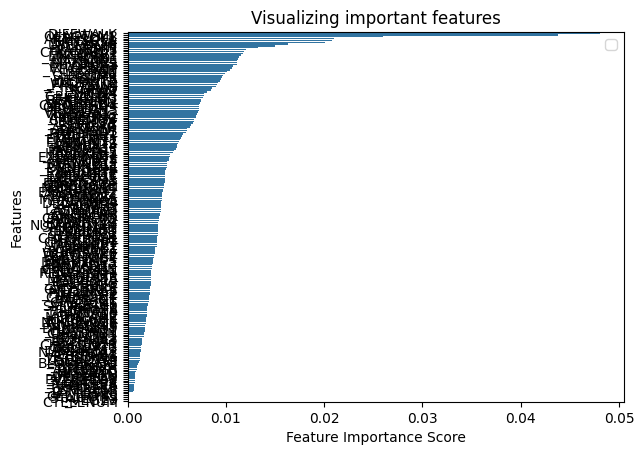

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp3, y=feature_imp3.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing important features")
plt.legend()
plt.show();

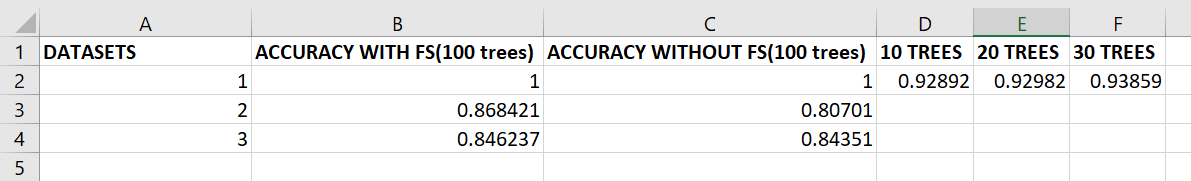

Dataset 1:

Accuracy with Feature Selection: 1.0
Accuracy without Feature Selection: 1.0
Both accuracies are the same, indicating that feature selection did not impact the model performance on Dataset 1. This suggests that all features in Dataset 1 are equally important for classification.
Moreover with increase in the number of tree estimators the accuracy of the model increases.
Adding more trees to a Random Forest generally boosts accuracy by reducing overfitting, but there's a limit where further trees don't significantly improve performance, balancing accuracy and efficiency is crucial.


Dataset 2:

Accuracy without Feature Selection: 0.8684
Accuracy with Feature Selection: 0.80701
Feature selection reduced the accuracy slightly on Dataset 2. This suggests that some features were important for classification, and removing them decreased the model performance.


Dataset 3:

Accuracy without Feature Selection: 0.84613
Accuracy with Feature Selection: 0.84351
Feature selection also reduced the accuracy on Dataset 3. This indicates that there are important features in the dataset that were not captured by the feature selection process, leading to a decrease in performance.